# Laboratorium 3

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection([]))

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


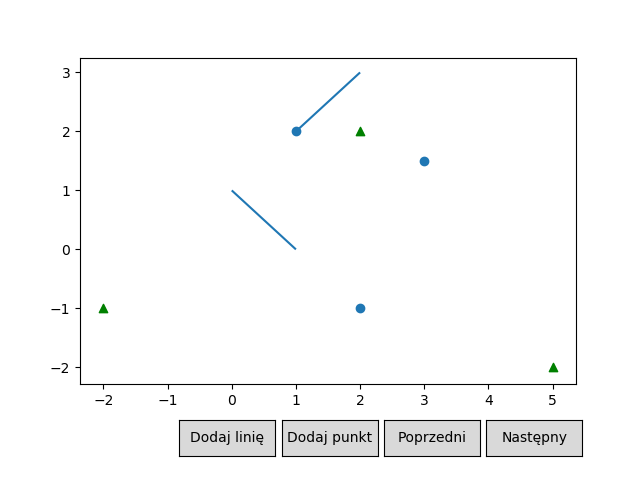

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


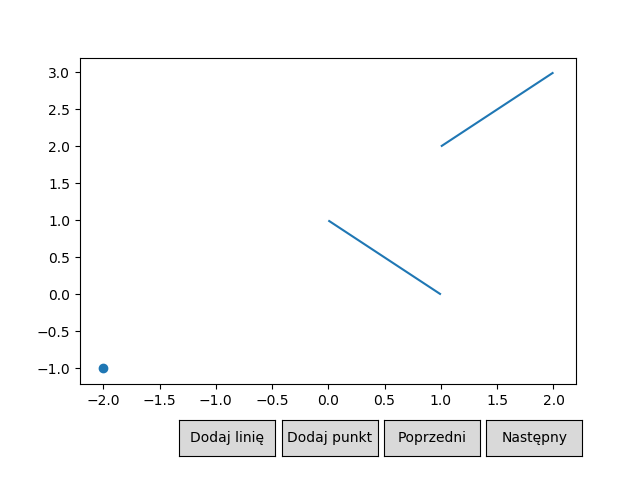

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

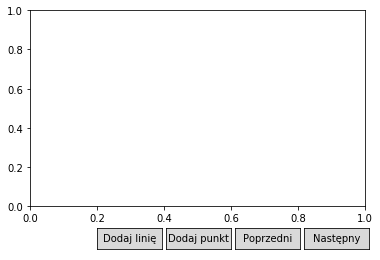

<Figure size 432x288 with 0 Axes>

In [7]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot([Scene( [ PointsCollection([]) ], 
              [LinesCollection( [[(1,2),(1,3)], [(1,3),(5,3)], [(5,3),(7,0)], [(7,0),(1,2)]], color = 'Orange')])])
plot1.draw()

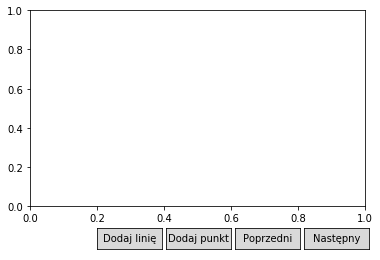

<Figure size 432x288 with 0 Axes>

In [8]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

In [3]:
import random

%matplotlib notebook

def det(a,b,c):
    #return a[0]*b[1]+b[0]*c[1]+c[0]*a[1]-a[1]*b[0]-b[1]*c[0]-c[0]*a[1]
    return (c[0]-a[0])*(b[1]-a[1])-(c[1]-a[1])*(b[0]-a[0])

def collin(x,y,z):
    return min(x[0],y[0]) <= z[0] and z[0] <= max(x[0],y[0]) and min(x[1],y[1]) <= z[1] and z[1] <= max(x[1],y[1])


def intersect(l1, l2):
    
    p1,p2=l1
    p3,p4=l2
    
    d1 = det(p3, p4, p1)
    d2 = det(p3, p4, p2)
    d3 = det(p1, p2, p3)
    d4 = det(p1, p2, p4)

    if ((d1 > 0 and d2 < 0) or (d1 < 0 and d2 > 0)) and ((d3 > 0 and d4 < 0) or (d3 < 0 and d4 > 0)):
        return True

    elif d1 == 0 and collin(p3, p4, p1):
        return True
    elif d2 == 0 and collin(p3, p4, p2):
        return True
    elif d3 == 0 and collin(p1, p2, p3):
        return True
    elif d4 == 0 and collin(p1, p2, p4):
        return True
    else:
        return False

def plotlos(T=0, n=5, r=100, name='somefile.json', namezap='somefilezap.json'):# T: 0-losowanie bez zapisu, 1-losowanie z zapisem, 2-z pliku
    sects=[]
    while len(sects)<n:
        tmp1=(random.random()*r, random.random()*r)
        tmp2=(random.random()*r, random.random()*r)
        if tmp1[0]==tmp2[0]:
            continue
        for i in sects:
            if i[0]==tmp1 or i[0]==tmp2 or i[1]==tmp1 or i[1]==tmp2:
                continue
        sects.append([tmp1, tmp2])
    
    

    for i in sects:
        #print(i)
        i.sort()
        #print(i)
            
    #scenes=[Scene([PointsCollection([])], [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])]
    scenes=[Scene([PointsCollection([])], [LinesCollection(sects)])]
    plot2 = Plot(scenes)
    
    if T == 1:#zapisanie
        with open(namezap, 'w') as file:
            file.write(plot.toJson())
            
    return plot2, sects


def plotzpl(name='somefilezap.json'):
    with open(name, 'r') as file:
        json = file.read()
    plot2 = Plot(json=json)
    sects=[]
    #print(js.loads(json))
    dic=js.loads(json)
    sects=dic[0]['lines']
    
    if len(sects)>1:
        sects=sects[0]+sects[1]
    else:
        sects=sects[0]
    
    for i in sects:
        i.sort()
    
    
    #sects=js.loads(json)['lines']
    return plot2, sects

def zapis(plot, name='trudny.json'):
    with open(name, 'w') as file:
        file.write(plot.toJson())


             
sects=[]
#plot = Plot()
#plot.draw()
#plot = Plot(scenes)
#plot, sects = plotlos(T=0, n=5, r=100)
#plot, sects = plotzpl('now.json')#('okilos.json')
#plot, sects = plotzpl('okilos.json')
plot, sects=plotzpl('trudny.json')
plot.draw()

    
#print(sects)#[0])
#zapis(plot, 'okilos.json')

FileNotFoundError: [Errno 2] No such file or directory: 'trudny.json'

In [4]:

# plot2 = Plot([plot.get_added_elements()])

scenes=[Scene([PointsCollection([])], [LinesCollection(sects)] + plot.get_added_lines())]
plot3 = Plot(scenes)
#zapis(plot3, 'trudny.json')
plot3.draw()

NameError: name 'plot' is not defined

In [8]:
pip install blist
from blist import sortedset


SyntaxError: invalid syntax (<ipython-input-8-0d437c07104c>, line 1)

In [7]:
class Line:
    def __init__(self, line, ix):
        self.start=line[0]
        self.end=line[1]
        self.a=(self.start[1]-self.end[1])/(self.start[0]-self.end[0])
        self.b=(self.start[1]-self.a*self.start[0])
        self.index=ix
    
    def setx(x):
        Line.x=x
        
    def seg(self):
        return [self.start,self.end]
    
    def __gt__(self,other):
        x=Line.x
        return self.a*x+self.b>other.a*x+other.b
    
    def __eq__(self, other):
        return self.start==other.start and self.end==other.end
        
    def __str__(self):
        return str(self.seg())

In [5]:
plot1, sects = plotlos(T=0, n=5, r=100)
#print(sects)
#plot1, sects = plotzpl('trudny.json')

def czytna(sects):
    ev=sortedset(key=lambda a: -a[0])
    maxy=-1e10
    miny=1e10
    for i in range(len(sects)):
        li=Line(sects[i], i)
        ev.add((sects[i][0][0], 0, i, li))
        ev.add((sects[i][1][0], 1, i, li))
        maxy=max(maxy, sects[i][0][1], sects[i][1][1])
        miny=min(miny, sects[i][0][1], sects[i][1][1])
    
    br=sortedset()
    
    scenes=[]
    scenes=[Scene([PointsCollection([])], [LinesCollection(sects)])]
    points=[]
    act=[]
    
    #print(sects)
    
    while len(ev)>0:
        cur=ev.pop()
        #ob=Line(sects[cur[2]])
        ob=cur[3]
        Line.setx(cur[0])
        if cur[1]==0:#start
            act.append(ob.seg())
            br.add(ob)
            ix=br.index(ob)
            le=ix-1
            ri=ix+1
            
            if le>=0:
                if intersect(ob.seg(), br[le].seg()):
                    return True,scenes
            if ri<len(br):
                if intersect(ob.seg(), br[ri].seg()):
                    return True,scenes

        tmp=[]
        for i in range(len(act)):
            tmp.append([])
            for j in range(len(act[i])):
                tmp[i].append(act[i][j])
        
        scenes+=[Scene([PointsCollection([])], [LinesCollection(sects), LinesCollection([[(cur[0],miny),(cur[0],maxy)]], color='red'), LinesCollection(tmp, color='black')])]#, LinesCollection(sects)])]
    
        if cur[1]==1:#end
            act.remove(ob.seg())
            
            ix=br.index(ob)
            le=ix-1
            ri=ix+1
            if le>=0 and ri<len(br):
                if intersect(br[le].seg(), br[ri].seg()):
                    return True,scenes
            br.discard(ob)
            
    return False,scenes


ans,scenes=czytna(sects)
print(ans)
plot=Plot(scenes)
plot.draw()

NameError: name 'sortedset' is not defined

In [14]:
def interpoint(a, b):
    x=(b.b-a.b)/(a.a-b.a)
    #print(a, x, b)
    return (x, a.a*x+a.b)

def same(a, b, eps=1e-10):
    return abs(a[0]-b[0])<eps and abs(a[1]-b[1])<eps

#a=Line([(0,0),(10, 10)])
#b=Line([(0,10),(11,0)])
#print(interpoint(a, b))

5

PKT:  (62.8785954034709, 44.6517641303876) 
Miedzy: [(0.44115472234084185, 15.706117220629135), (99.22826652748633, 61.50326755787482)]  i  [(23.74497637835098, 72.34778720938337), (83.65654567178899, 29.946592349669544)]

PKT:  (48.99253670837311, 38.21426529040139) 
Miedzy: [(24.87997571027405, 9.264209094214603), (80.93769443713863, 76.56830456133247)]  i  [(0.44115472234084185, 15.706117220629135), (99.22826652748633, 61.50326755787482)]

PKT:  (51.25022143482957, 52.88150934255296) 
Miedzy: [(43.41682406531944, 41.11747888277826), (80.77456544131627, 97.2205446057285)]  i  [(23.74497637835098, 72.34778720938337), (83.65654567178899, 29.946592349669544)]

PKT:  (57.5156407637747, 48.4472862204169) 
Miedzy: [(43.41682406531944, 41.11747888277826), (80.77456544131627, 97.2205446057285)]  i  [(23.74497637835098, 72.34778720938337), (83.65654567178899, 29.946592349669544)]

PKT:  (68.40500261659854, 78.6441968245644) 
Miedzy: [(43.41682406531944, 41.11747888277826), (80.774565441316

<IPython.core.display.Javascript object>


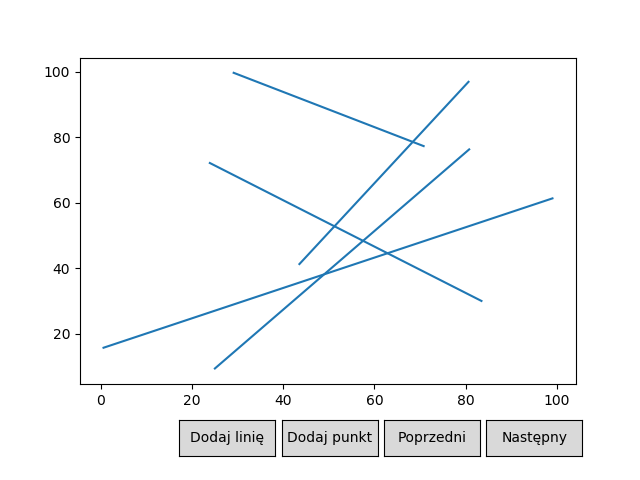

In [34]:
plot1, sects = plotlos(T=0, n=5, r=100)
#print(sects)
#plot1, sects = plotzpl('trud.json')

def gdzietna(sects):
#     print(sects)
    ev=sortedset(key=lambda a: -a[0])
    maxy=-1e10
    miny=1e10
    for i in range(len(sects)):
        li=Line(sects[i], i)
        ev.add((sects[i][0][0], 0, i, li, 0))
        ev.add((sects[i][1][0], 1, i, li, 0))
        maxy=max(maxy, sects[i][0][1], sects[i][1][1])
        miny=min(miny, sects[i][0][1], sects[i][1][1])
    
    br=sortedset()
    
    scenes=[]
    scenes=[Scene([PointsCollection([])], [LinesCollection(sects)])]
    points=[]
    act=[]
    
    pset = set()
    
    while len(ev)>0:
        cur=ev.pop()
        if cur[1]==0 or cur[1]==1:
            ob=cur[3]
        
        if cur[1]==0:#start
            
            Line.setx(cur[0])
            act.append(ob.seg())
            br.add(ob)
            ix=br.index(ob)
            le=ix-1
            ri=ix+1
            
            if le>=0:
                if intersect(ob.seg(), br[le].seg()):
                    inter=interpoint(ob, br[le])
                    if not (round(inter[0], 7), round(inter[1], 7)) in pset:
                        points.append(((inter[0], inter[1]), br[le].index, ob.index))
                        pset.add((round(inter[0], 7), round(inter[1], 7)))
                        ev.add((inter[0], 3, inter[1], br[le], ob))
            if ri<len(br):
                if intersect(ob.seg(), br[ri].seg()):
                    inter=interpoint(ob, br[ri])
                    if not (round(inter[0], 7), round(inter[1], 7)) in pset:
                        points.append(((inter[0], inter[1]), ob.index, br[ri].index))
                        pset.add((round(inter[0], 7), round(inter[1], 7)))
                        ev.add((inter[0], 3, inter[1], ob, br[ri]))
        
        elif cur[1]==1:#end
            act.remove(ob.seg())
            
            ix=br.index(ob)
            le=ix-1
            ri=ix+1
            if le>=0 and ri<len(br):
                if intersect(br[le].seg(), br[ri].seg()):
                    inter=interpoint(br[le], br[ri])
                    if not (round(inter[0], 7), round(inter[1], 7)) in pset:
                        ev.add((inter[0], 3, inter[1], br[le], br[ri]))
                        points.append(((inter[0], inter[1]), br[le].index, br[ri].index))
                        pset.add((round(inter[0], 7), round(inter[1], 7)))
            br.discard(ob)
            
        else:#przeciecie 
            
            a=cur[3]
            b=cur[4]
            
            br.discard(a)
            br.discard(b)
            Line.setx(cur[0]+1e-5)
            
            br.add(a)
            br.add(b)
            
            le=br.index(b)
            ri=br.index(a)
            
            if le-1>=0:
                if intersect(br[le-1].seg(), br[le].seg()):
                    inter=interpoint(br[le-1], br[le])
                    if not (round(inter[0], 7), round(inter[1], 7)) in pset:
                        points.append(((inter[0], inter[1]), a.index, b.index))
                        pset.add((round(inter[0], 7), round(inter[1], 7)))
                        ev.add((inter[0], 3, inter[1], br[le-1], br[le]))
            if ri+1<len(br):
                if intersect(br[ri].seg(), br[ri+1].seg()):
                    inter=interpoint(br[ri], br[ri+1])
                    if not (round(inter[0], 7), round(inter[1], 7)) in pset:
                        points.append(((inter[0], inter[1]), a.index, b.index))
                        pset.add((round(inter[0], 7), round(inter[1], 7)))
                        ev.add((inter[0], 3, inter[1], br[ri], br[ri+1]))
                    

            
        tmpl=[]
        for i in range(len(act)):
            tmpl.append([])
            for j in range(len(act[i])):
                tmpl[i].append(act[i][j])
        
        tmpp=[]
        for i in range(len(points)):
            tmpp.append(points[i][0])
        
        scenes+=[Scene([PointsCollection(tmpp, color='purple', marker='X')], [LinesCollection(sects), LinesCollection([[(cur[0],miny),(cur[0],maxy)]], color='red'), LinesCollection(tmpl, color='black')])]#, LinesCollection(sects)])]
    
        
    return points,scenes


ans,scenes=gdzietna(sects)
print(len(ans))
for i in ans:
    print('\nPKT: ',i[0],'\nMiedzy:', sects[i[1]], ' i ', sects[i[2]] )
plot=Plot(scenes)
plot.draw()